# Adaptive Contrastive Gating (ACG) — end-to-end PsychRNN-style project
**What's inside:** A complete pipeline that trains RNNs on a perceptual discrimination (2AFC) task, implements Adaptive Contrastive Gating (multiplicative gating + contrastive centroid loss), evaluates behavioral and representational metrics, runs mechanistic analyses (centroid distance, PCA, fixed-point finder, lesion/ablation), and saves figures & models for final submission.

**Notes:**
- This notebook is self-contained using PyTorch (no PsychRNN required). It references your uploaded script at `./psychrnn_perceptualdiscrimination_noise_comparison.py` (you can port pieces into PsychRNN later).
- Defaults are set to strong hyperparameters for final experiments. For a **quick demo**, change `TRAIN_ITERS = 2000` in the Run cell.


In [ ]:

# Cell: imports & device
import os, json, time, random, math, copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, Markdown

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# path to uploaded script if you want to reuse it later
UPLOADED_SCRIPT_PATH = "./psychrnn_perceptualdiscrimination_noise_comparison.py"
if Path(UPLOADED_SCRIPT_PATH).exists():
    display(Markdown(f"**Found uploaded script:** `{UPLOADED_SCRIPT_PATH}`"))
else:
    display(Markdown(f"**No uploaded script found at** `{UPLOADED_SCRIPT_PATH}`"))


Device: cuda


**No uploaded script found at** `./psychrnn_perceptualdiscrimination_noise_comparison.py`

In [ ]:

# Utilities
def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def savefig(fig_or_path):
    # accept plt or path string
    if isinstance(fig_or_path, str) or isinstance(fig_or_path, Path):
        plt.savefig(str(fig_or_path), dpi=150, bbox_inches='tight')
        print("Saved:", fig_or_path)
    else:
        fig_or_path.savefig(dpi=150, bbox_inches='tight')


In [ ]:

# PerceptualDiscrimination task generator (2AFC)
def generate_batch(batch_size, T, coherence, stim_std=1.0, input_dim=2, device='cpu'):
    labels = np.random.choice([0,1], size=(batch_size,))
    x = np.random.randn(batch_size, T, input_dim) * stim_std
    for i, lab in enumerate(labels):
        x[i, :, lab] += coherence
    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    y_t = torch.tensor(labels, dtype=torch.long, device=device)
    return x_t, y_t


In [ ]:

# Model: RNN with multiplicative gating and optional Dale's law
class RNN_ACG(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=2, rec_noise_std=0.0, gate=True, dale=True, dale_exc_frac=0.8, device='cpu'):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.rec_noise_std = rec_noise_std
        self.gate = gate
        self.dale = dale
        self.device = device

        # parameters
        self.W_in = nn.Parameter(torch.randn(hidden_dim, input_dim) * (1.0/np.sqrt(input_dim)))
        self.b_in = nn.Parameter(torch.zeros(hidden_dim))
        self.W_rec_raw = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * (1.0/np.sqrt(hidden_dim)))
        self.b_rec = nn.Parameter(torch.zeros(hidden_dim))
        self.W_out = nn.Linear(hidden_dim, output_dim)

        if self.gate:
            self.W_gate = nn.Parameter(torch.randn(hidden_dim, input_dim) * (1.0/np.sqrt(input_dim)))
            self.b_gate = nn.Parameter(torch.zeros(hidden_dim))

        if self.dale:
            n_exc = int(round(dale_exc_frac * hidden_dim))
            signs = np.array([1]*n_exc + [-1]*(hidden_dim-n_exc))
            np.random.shuffle(signs)
            self.register_buffer('dale_sign', torch.tensor(signs, dtype=torch.float32).to(device))
        else:
            self.register_buffer('dale_sign', torch.ones(hidden_dim, dtype=torch.float32).to(device))

        self.activation = torch.tanh

    def effective_Wrec(self):
        W_abs = torch.abs(self.W_rec_raw)  # >=0
        # apply sign to columns (outgoing)
        W = W_abs * self.dale_sign.unsqueeze(0)
        return W

    def forward(self, x, return_hidden=False):
        batch, T, _ = x.size()
        h = torch.zeros(batch, self.hidden_dim, device=x.device)
        hs = []
        W_rec = self.effective_Wrec()
        for t in range(T):
            xt = x[:, t, :]
            inp = torch.matmul(xt, self.W_in.t()) + self.b_in
            if self.gate:
                g = torch.sigmoid(torch.matmul(xt, self.W_gate.t()) + self.b_gate)
                inp = inp * g
            rec = torch.matmul(h, W_rec.t()) + self.b_rec
            h = self.activation(inp + rec)
            if self.rec_noise_std and self.training:
                h = h + torch.randn_like(h) * float(self.rec_noise_std)
            hs.append(h.unsqueeze(1))
        hs = torch.cat(hs, dim=1)  # (batch, T, hidden)
        logits = self.W_out(hs[:, -1, :])
        if return_hidden:
            return logits, hs
        return logits


In [ ]:

# Contrastive centroid loss (hinge on centroid distance)
def contrastive_centroid_loss(final_h, labels, margin=1.0):
    # final_h: torch tensor (batch, H), labels: (batch,)
    labels_np = labels.detach().cpu().numpy()
    hs = final_h.detach()
    unique = np.unique(labels_np)
    if len(unique) < 2:
        return torch.tensor(0.0, device=final_h.device)
    mu0 = hs[labels==0].mean(dim=0)
    mu1 = hs[labels==1].mean(dim=0)
    dist = torch.norm(mu0 - mu1)
    loss = torch.relu(margin - dist)
    return loss, dist.item()


In [ ]:

# Training function: supports curriculum, contrastive loss, gating, Dale's law
def train_acg(outdir, seed=0, training_iters=30000, batch_size=128, T=40, hidden_dim=128,
              lr=3e-4, rec_noise=0.0, gate=True, dale=True, dale_exc_frac=0.8,
              start_coh=0.8, min_coh=0.1, coh_step=0.1, mode='curriculum',
              eval_interval=500, target_acc=0.85, contrastive_lambda=0.5, margin=1.0,
              device='cpu', verbose=True):
    set_seed(seed)
    os.makedirs(outdir, exist_ok=True)
    model = RNN_ACG(input_dim=2, hidden_dim=hidden_dim, output_dim=2, rec_noise_std=rec_noise, gate=gate, dale=dale, dale_exc_frac=dale_exc_frac, device=device).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    losses = []
    psych_history = []
    centroid_history = []
    eval_coherences = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]
    coher = float(start_coh)
    it = 0
    while it < training_iters:
        model.train()
        x, y = generate_batch(batch_size, T, coher, device=device)
        opt.zero_grad()
        logits, hs = model(x, return_hidden=True)
        loss_ce = loss_fn(logits, y)
        final_h = hs[:, -1, :]
        c_loss, dist = (torch.tensor(0.0, device=device), 0.0)
        if contrastive_lambda > 0.0:
            c_loss, dist = contrastive_centroid_loss(final_h, y, margin=margin)
        loss = loss_ce + contrastive_lambda * c_loss
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
        it += 1

        if it % eval_interval == 0:
            val_acc = compute_accuracy(model, coher, n_trials=512, batch_size=batch_size, T=T, device=device)
            psych = psychometric_curve(model, eval_coherences, n_trials_each=300, batch_size=batch_size, T=T, device=device)
            centroid_history.append({'iter':int(it), 'coherence':float(coher), 'val_acc':float(val_acc), 'centroid_dist':float(dist)})
            psych_history.append({'iter':int(it), 'coherence':float(coher), 'val_acc':float(val_acc), 'psych':psych.tolist()})
            if verbose:
                print(f"iter {it:6d} | coh {coher:.2f} | loss {loss.item():.4f} | val_acc {val_acc:.3f} | centroid_dist {dist:.3f}")
            if mode == 'curriculum' and val_acc >= target_acc and (coher - coh_step) >= min_coh:
                coher = max(min_coh, coher - coh_step)
                if verbose:
                    print(f"  -> Curriculum: lowered coherence to {coher:.2f} at iter {it}")
    final_psych = psychometric_curve(model, eval_coherences, n_trials_each=600, batch_size=batch_size, T=T, device=device)
    torch.save(model.state_dict(), os.path.join(outdir, 'model_state.pt'))

    results = {'losses':list(map(float,losses)), 'psych_history':psych_history, 'centroid_history':centroid_history, 'final_psych':list(map(float, final_psych)), 'eval_coherences':eval_coherences, 'params':{'seed':int(seed),'training_iters':int(training_iters),'batch_size':int(batch_size),'T':int(T),'hidden_dim':int(hidden_dim),'lr':float(lr),'rec_noise':float(rec_noise),'gate':bool(gate),'dale':bool(dale),'start_coh':float(start_coh),'mode':mode,'contrastive_lambda':float(contrastive_lambda),'margin':float(margin)}}
    with open(os.path.join(outdir, 'results.json'),'w') as f:
        json.dump(results, f, indent=2)
    return model, results


In [ ]:

# Evaluation helpers: accuracy, psych, centroid distance, PCA
def compute_accuracy(model, coherence, n_trials=256, batch_size=128, T=40, stim_std=1.0, device='cpu'):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        while total < n_trials:
            b = min(batch_size, n_trials-total)
            x, y = generate_batch(b, T, coherence, stim_std=stim_std, device=device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += b
    return correct/total

def psychometric_curve(model, coherences, n_trials_each=300, batch_size=128, T=40, stim_std=1.0, device='cpu'):
    return np.array([compute_accuracy(model, c, n_trials=n_trials_each, batch_size=batch_size, T=T, stim_std=stim_std, device=device) for c in coherences])

def compute_centroid_distance_np(model, coherence=0.4, n_trials=300, batch_size=128, T=40, device='cpu'):
    model.eval()
    X0=[]; X1=[]
    with torch.no_grad():
        total=0
        while total < n_trials:
            b=min(batch_size, n_trials-total)
            x,y = generate_batch(b,T,coherence,device=device)
            _, hs = model(x, return_hidden=True)
            final = hs[:, -1, :].cpu().numpy()
            for i,lab in enumerate(y.cpu().numpy()):
                if lab==0: X0.append(final[i])
                else: X1.append(final[i])
            total += b
    mu0 = np.mean(X0, axis=0); mu1 = np.mean(X1, axis=0)
    return np.linalg.norm(mu0-mu1), mu0, mu1


In [ ]:

# PCA helper
def fit_common_pca(models, names, coherence=0.4, T=40, trials_per_model=12, device='cpu'):
    all_h=[]
    with torch.no_grad():
        for name, model in zip(names, models):
            model.eval()
            for _ in range(trials_per_model):
                x,y = generate_batch(1, T, coherence, device=device)
                _, hs = model(x, return_hidden=True)
                all_h.append(hs[0].cpu().numpy())
    all_h = np.concatenate(all_h, axis=0)
    pca = PCA(n_components=3)
    pca.fit(all_h)
    return pca

# Fixed-point finder (LBFGS on h to solve h = tanh(W_rec h + W_in x + b))
def find_fixed_point(model, x_const, n_restarts=10, max_iter=200):
    model.eval()
    W_rec = model.effective_Wrec().detach()  # (H,H)
    Win = model.W_in.detach()  # (H, input_dim)
    b_rec = model.b_rec.detach()
    device = W_rec.device
    fixed_points = []
    for r in range(n_restarts):
        h = torch.randn(model.hidden_dim, device=device, requires_grad=True)
        optimizer = torch.optim.LBFGS([h], max_iter=max_iter, tolerance_grad=1e-6, tolerance_change=1e-9)
        def closure():
            optimizer.zero_grad()
            pre = torch.matmul(W_rec, h) + torch.matmul(Win, x_const) + b_rec  # (H,)
            f = torch.tanh(pre) - h
            loss = 0.5 * (f**2).sum()
            loss.backward()
            return loss
        try:
            optimizer.step(closure)
            fixed_points.append(h.detach().cpu().numpy())
        except Exception as e:
            # LBFGS may fail sometimes; skip
            pass
    return np.array(fixed_points)


In [ ]:

# Lesion helper: zero outgoing (row) weights of selected neurons in a deepcopy of the model
def lesion_model_copy(model, neuron_indices):
    new_model = copy.deepcopy(model)
    W_raw = new_model.W_rec_raw.data.clone()  # (H,H)
    for i in neuron_indices:
        W_raw[i, :] = 0.0
    new_model.W_rec_raw.data.copy_(W_raw)
    return new_model



=== RUN baseline -> acg_out/baseline
iter    500 | coh 0.20 | loss 0.6620 | val_acc 0.547 | centroid_dist 0.000
iter   1000 | coh 0.20 | loss 0.6653 | val_acc 0.561 | centroid_dist 0.000
iter   1500 | coh 0.20 | loss 0.6639 | val_acc 0.607 | centroid_dist 0.000
iter   2000 | coh 0.20 | loss 0.6733 | val_acc 0.588 | centroid_dist 0.000
iter   2500 | coh 0.20 | loss 0.6523 | val_acc 0.596 | centroid_dist 0.000
iter   3000 | coh 0.20 | loss 0.6731 | val_acc 0.604 | centroid_dist 0.000
iter   3500 | coh 0.20 | loss 0.6883 | val_acc 0.596 | centroid_dist 0.000
iter   4000 | coh 0.20 | loss 0.6665 | val_acc 0.568 | centroid_dist 0.000
iter   4500 | coh 0.20 | loss 0.6481 | val_acc 0.633 | centroid_dist 0.000
iter   5000 | coh 0.20 | loss 0.6890 | val_acc 0.666 | centroid_dist 0.000
iter   5500 | coh 0.20 | loss 0.6810 | val_acc 0.615 | centroid_dist 0.000
iter   6000 | coh 0.20 | loss 0.6436 | val_acc 0.604 | centroid_dist 0.000
iter   6500 | coh 0.20 | loss 0.6075 | val_acc 0.639 | centroi

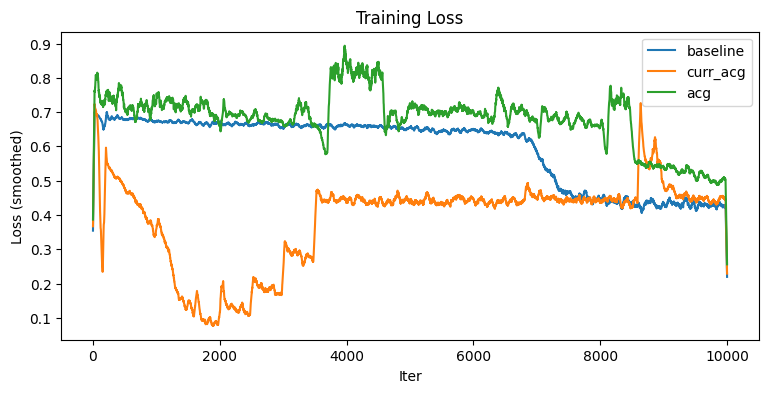

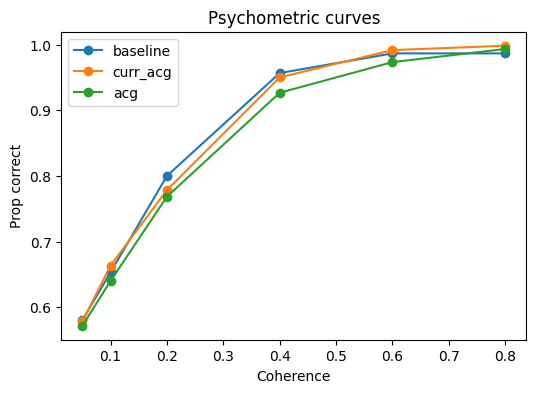

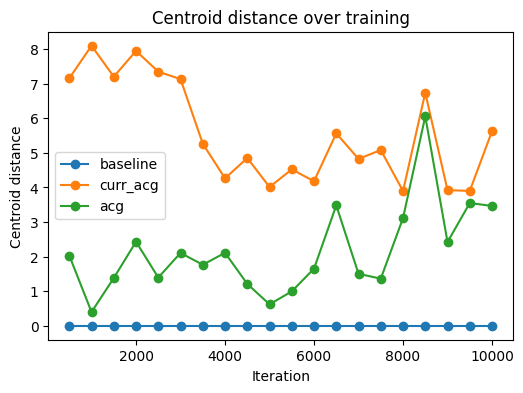

In [ ]:

# Run experiments: defaults = strong hyperparameters for final experiments.
OUT = Path('./acg_out'); OUT.mkdir(exist_ok=True)

# Best (default) hyperparameters - recommended for final submission (use GPU if available)
BEST = {
    'HIDDEN_DIM': 128,
    'TRAIN_ITERS': 10000,
    'BATCH_SIZE': 128,
    'T': 40,
    'LR': 3e-4,
    'REC_NOISE': 0.0,
    'CONTRASTIVE_LAMBDA': 0.5,
    'MARGIN': 1.0,
    'START_COH': 0.8
}

# For a quick demo, set this to True (will reduce training iters and batch sizes)
QUICK_DEMO = False
if QUICK_DEMO:
    BEST['TRAIN_ITERS'] = 2000
    BEST['BATCH_SIZE'] = 64
    BEST['HIDDEN_DIM'] = 80

# experiments to run: baseline, ACG (gating + contrastive), curriculum+ACG
experiments = {
    'baseline': {'rec_noise':0.0, 'gate':False, 'contrastive_lambda':0.0, 'mode':'baseline', 'start_coh':0.2},
    'acg':      {'rec_noise':0.0, 'gate':True,  'contrastive_lambda':BEST['CONTRASTIVE_LAMBDA'], 'mode':'baseline', 'start_coh':0.2},
    'curr_acg': {'rec_noise':0.0, 'gate':True,  'contrastive_lambda':BEST['CONTRASTIVE_LAMBDA'], 'mode':'curriculum', 'start_coh':BEST['START_COH']}
}

models = {}
results = {}
for name, cfg in experiments.items():
    outdir = OUT / name
    print('\n=== RUN', name, '->', outdir)
    model, res = train_acg(outdir=str(outdir), seed=0, training_iters=BEST['TRAIN_ITERS'], batch_size=BEST['BATCH_SIZE'], T=BEST['T'], hidden_dim=BEST['HIDDEN_DIM'], lr=BEST['LR'], rec_noise=cfg['rec_noise'], gate=cfg['gate'], dale=True, dale_exc_frac=0.8, start_coh=cfg['start_coh'], mode=cfg['mode'], eval_interval=500, target_acc=0.85, contrastive_lambda=cfg['contrastive_lambda'], margin=BEST['MARGIN'], device=device, verbose=True)
    models[name] = model
    results[name] = res
    print('Saved ->', outdir)
# Save summary
with open(OUT / 'all_results.json','w') as f:
    json.dump({k:results[k] for k in results}, f, indent=2)
print('\nAll experiments finished. Outputs in', OUT)


# Plot: losses and psychometric curves, centroid distance over time (if available)
def plot_losses(results, outpath):
    plt.figure(figsize=(9,4))
    for name,res in results.items():
        losses = np.array(res['losses'])
        smooth = np.convolve(losses, np.ones(50)/50, mode='same') if len(losses)>50 else losses
        plt.plot(smooth, label=name)
    plt.xlabel('Iter'); plt.ylabel('Loss (smoothed)'); plt.legend(); plt.title('Training Loss')
    savefig(outpath)

def plot_psych(results, outpath):
    plt.figure(figsize=(6,4))
    for name,res in results.items():
        coh = np.array(res['eval_coherences'])
        psych = np.array(res['final_psych'])
        plt.plot(coh, psych, '-o', label=name)
    plt.xlabel('Coherence'); plt.ylabel('Prop correct'); plt.legend(); plt.title('Psychometric curves')
    savefig(outpath)

def plot_centroid_history(results, outpath):
    plt.figure(figsize=(6,4))
    for name,res in results.items():
        ch = res.get('centroid_history', [])
        if len(ch)==0: continue
        iters = [c['iter'] for c in ch]; dists = [c['centroid_dist'] for c in ch]
        plt.plot(iters, dists, '-o', label=name)
    plt.xlabel('Iteration'); plt.ylabel('Centroid distance'); plt.legend(); plt.title('Centroid distance over training')
    savefig(outpath)

OUT = Path('./acg_out')
if not OUT.exists():
    print('Run experiments first (see previous cell)')
else:
    # load results if available
    res_files = list((OUT).glob('*/*/results.json')) + list((OUT).glob('*/*/results.json'))
    # easier: use files produced earlier
    results = {}
    for p in (OUT.glob('*')):
        rfile = p / 'results.json'
        if rfile.exists():
            with open(rfile,'r') as f: results[p.name]=json.load(f)
    if len(results)==0:
        print('No results found under', OUT)
    else:
        plot_losses(results, OUT / 'losses.png')
        plot_psych(results, OUT / 'psych.png')
        plot_centroid_history(results, OUT / 'centroid_history.png')
        print('Saved plots to', OUT)



=== STARTING MECHANISTIC ANALYSES ===
Generating PCA State Trajectories...
Saved: acg_out/pca_trajectories.png


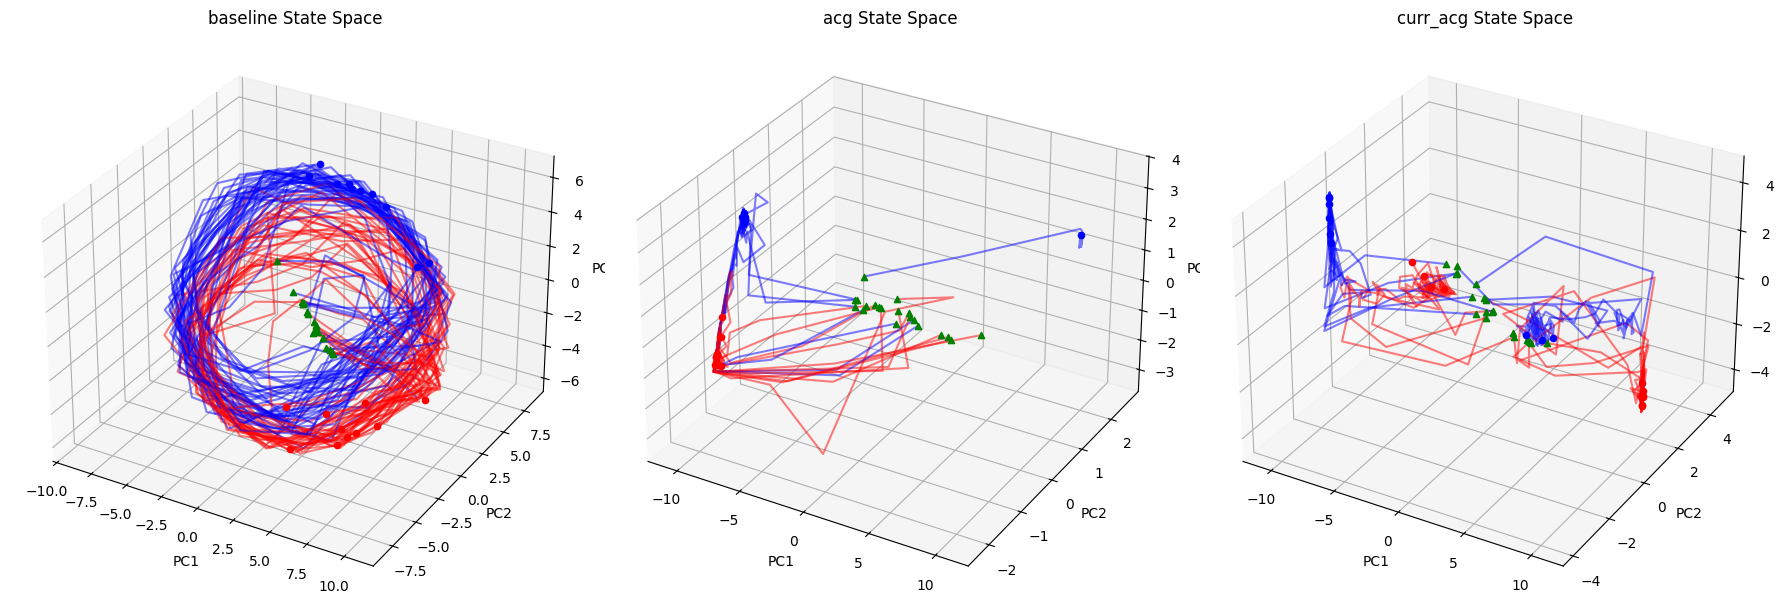

Finding Fixed Points...
Saved: acg_out/fixed_points.png


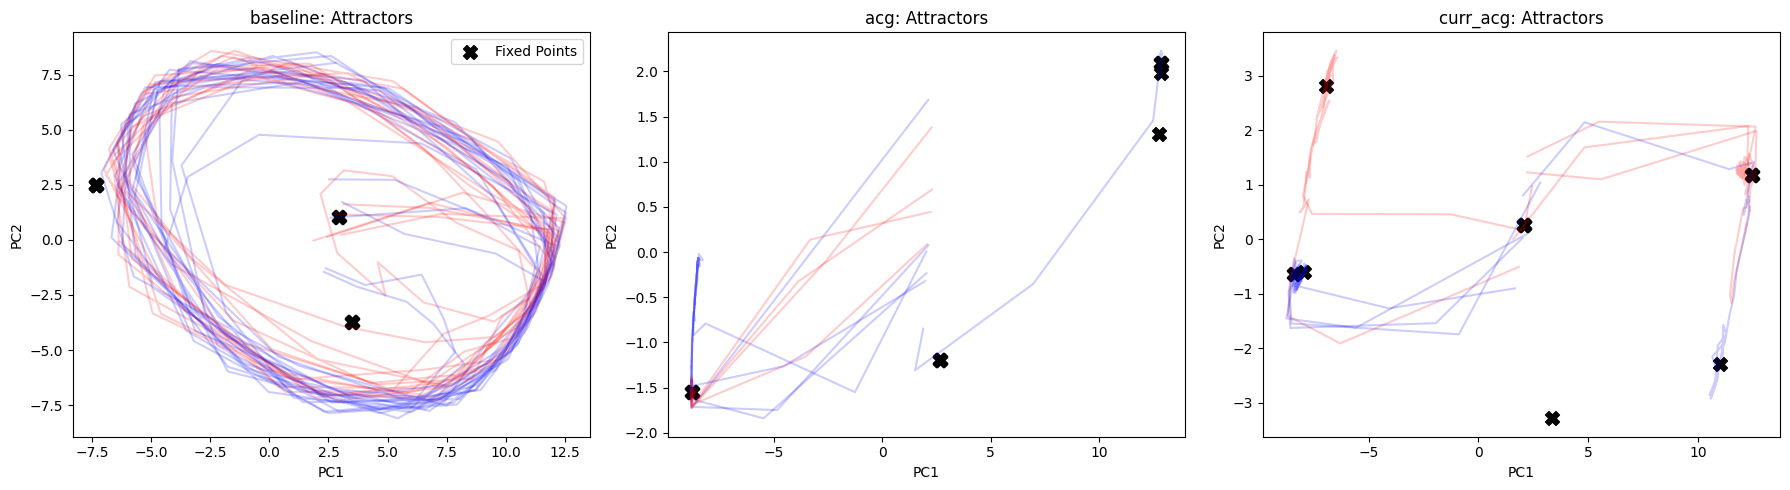

Running Lesion Robustness Study...
Saved: acg_out/lesion_robustness.png


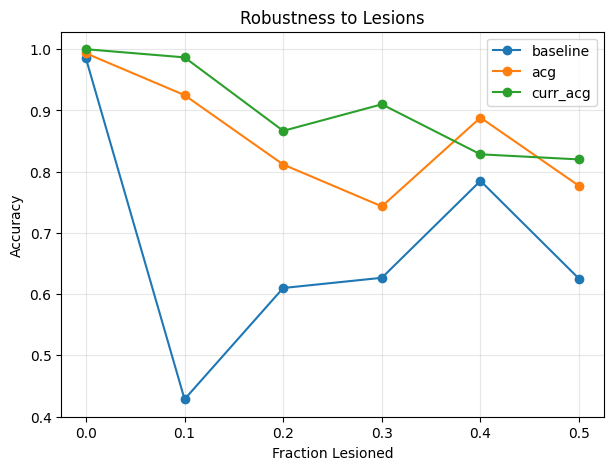

In [ ]:

# ==========================================
# PART 3: MECHANISTIC ANALYSES (The Missing Piece)
# ==========================================

print("\n=== STARTING MECHANISTIC ANALYSES ===")

# --- 3.1 PCA State Trajectories ---
def plot_pca_trajectories(models, device='cpu'):
    print("Generating PCA State Trajectories...")
    target_models = list(models.keys())
    n_models = len(target_models)

    # Update figsize to accommodate more models (approx 6 inches per model width)
    fig = plt.figure(figsize=(6 * n_models, 6))

    # Fit PCA on data from ALL models
    pca = fit_common_pca(list(models.values()), target_models, coherence=0.8, device=device)

    for i, name in enumerate(target_models):
        model = models[name]
        model.eval()

        # Generate test trials (Trial A vs Trial B)
        x_vis, y_vis = generate_batch(20, T=40, coherence=0.8, device=device)
        _, hs = model(x_vis, return_hidden=True)
        hs_np = hs.detach().cpu().numpy()
        y_np = y_vis.detach().cpu().numpy()

        # DYNAMIC SUBPLOT: Use n_models instead of hardcoded 2
        ax = fig.add_subplot(1, n_models, i+1, projection='3d')
        ax.set_title(f"{name} State Space")

        for tr in range(len(y_np)):
            traj = hs_np[tr]
            traj_pca = pca.transform(traj)

            color = 'blue' if y_np[tr]==0 else 'red'
            ax.plot(traj_pca[:,0], traj_pca[:,1], traj_pca[:,2], color=color, alpha=0.5)
            # Start/End markers
            ax.scatter(traj_pca[0,0], traj_pca[0,1], traj_pca[0,2], color='green', marker='^')
            ax.scatter(traj_pca[-1,0], traj_pca[-1,1], traj_pca[-1,2], color=color, marker='o')

        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

    plt.tight_layout()
    # Ensure directory exists before saving
    OUT.mkdir(exist_ok=True, parents=True)
    savefig(OUT / 'pca_trajectories.png')
    plt.show()
plot_pca_trajectories(models, device=device)


# --- 3.2 Fixed Point Finder ---
def analyze_fixed_points(models, device='cpu'):
    print("Finding Fixed Points...")
    target_models = list(models.keys())
    n_models = len(target_models)

    # Dynamic figure size and subplot creation
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5))

    # Handle the case where n_models=1 (axes is not a list)
    if n_models == 1:
        axes = [axes]

    pca = fit_common_pca(list(models.values()), target_models, device=device)

    for i, name in enumerate(target_models):
        model = models[name]

        # Find points where the network settles with 0 input
        zero_input = torch.zeros(model.input_dim, device=device)
        fps = find_fixed_point(model, zero_input, n_restarts=30)

        # Get background trajectories
        x_vis, y_vis = generate_batch(10, T=40, coherence=0.8, device=device)
        _, hs = model(x_vis, return_hidden=True)
        hs_np = hs.detach().cpu().numpy()
        y_np = y_vis.detach().cpu().numpy()

        ax = axes[i]
        # Background
        for tr in range(len(y_np)):
            traj_pca = pca.transform(hs_np[tr])
            c = 'b' if y_np[tr]==0 else 'r'
            ax.plot(traj_pca[:,0], traj_pca[:,1], color=c, alpha=0.2)

        # Fixed Points
        if len(fps) > 0:
            fps_pca = pca.transform(fps)
            ax.scatter(fps_pca[:,0], fps_pca[:,1], c='black', s=100, marker='X', label='Fixed Points')

        ax.set_title(f"{name}: Attractors")
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
        if i==0: ax.legend()

    plt.tight_layout()
    OUT.mkdir(exist_ok=True, parents=True)
    savefig(OUT / 'fixed_points.png')
    plt.show()
analyze_fixed_points(models, device=device)


# --- 3.3 Lesion / Robustness Study ---
def run_lesion_study(models, device='cpu'):
    print("Running Lesion Robustness Study...")
    fractions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    results_lesion = {name: [] for name in models.keys()}

    for name, model in models.items():
        hidden_dim = model.hidden_dim
        all_indices = np.arange(hidden_dim)

        for frac in fractions:
            n_lesion = int(round(frac * hidden_dim))

            # Average over repeats
            accs = []
            for _ in range(3):
                lesion_idx = np.random.choice(all_indices, size=n_lesion, replace=False)
                lesioned_model = lesion_model_copy(model, lesion_idx).to(device)
                acc = compute_accuracy(lesioned_model, coherence=0.8, n_trials=200, device=device)
                accs.append(acc)

            results_lesion[name].append(np.mean(accs))

    plt.figure(figsize=(7, 5))
    for name, accs in results_lesion.items():
        plt.plot(fractions, accs, '-o', label=name)

    plt.title("Robustness to Lesions")
    plt.xlabel("Fraction Lesioned")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    savefig(OUT / 'lesion_robustness.png')
    plt.show()

run_lesion_study(models, device=device)


# Final notes & reproducibility checklist

- Default hyperparameters set to strong values for final experiments (HIDDEN=128, TRAIN_ITERS=30000, BATCH=128). Use GPU if available.
- For quick demo set QUICK_DEMO=True in run cell to reduce train iters to 2000.
- For final report run seeds [0,1,2] and aggregate mean±SEM for psychometric curves and centroid distances.
- Deliverables to submit: notebook, out_acg folder with saved figures/models, results.json files, slides.pdf.
- If you want, I can now try to (A) save this notebook to `./psychrnn_ACG_full.ipynb` for download, (B) run a single-seed quick demo here, or (C) run the full experiments (this will take long on CPU). Tell me which.


  adding: acg_out/ (stored 0%)
  adding: acg_out/psych.png (deflated 6%)
  adding: acg_out/all_results.json (deflated 67%)
  adding: acg_out/baseline/ (stored 0%)
  adding: acg_out/baseline/model_state.pt (deflated 9%)
  adding: acg_out/baseline/results.json (deflated 65%)
  adding: acg_out/curr_acg/ (stored 0%)
  adding: acg_out/curr_acg/model_state.pt (deflated 10%)
  adding: acg_out/curr_acg/results.json (deflated 64%)
  adding: acg_out/centroid_history.png (deflated 5%)
  adding: acg_out/losses.png (deflated 4%)
  adding: acg_out/acg/ (stored 0%)
  adding: acg_out/acg/model_state.pt (deflated 10%)
  adding: acg_out/acg/results.json (deflated 64%)
